In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("Train.csv")
tst = pd.read_csv("Test.csv")
data.merge(tst)
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
data = data.drop(columns='ID')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 630.4+ KB


In [5]:
data.isnull().values.sum()

1582

In [6]:
data.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [7]:
from scipy import stats
mode = stats.mode(data['Family_Size'])
md = mode[0][0]
values = {'Family_Size': md}
data.fillna(value=values, inplace = True)
mode = stats.mode(data['Work_Experience'])
md = mode[0][0]
values = {'Work_Experience': md}
data.fillna(value=values, inplace = True)
data.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


In [8]:
nulls = ['Ever_Married','Profession', 'Graduated', 'Var_1']
cat_data = data.select_dtypes(include=['object']).copy()
for feature in nulls:
    cat_data = cat_data.fillna(cat_data[feature].value_counts().index[0])

In [9]:
cat_data.isnull().sum()

Gender            0
Ever_Married      0
Graduated         0
Profession        0
Spending_Score    0
Var_1             0
Segmentation      0
dtype: int64

In [10]:
cat_data.columns.values

array(['Gender', 'Ever_Married', 'Graduated', 'Profession',
       'Spending_Score', 'Var_1', 'Segmentation'], dtype=object)

In [11]:
categoricals = cat_data.columns.values
for categorical in categoricals:
    data = data.drop(columns=categorical)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              8068 non-null   int64  
 1   Work_Experience  8068 non-null   float64
 2   Family_Size      8068 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 189.2 KB


In [13]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          8068 non-null   object
 1   Ever_Married    8068 non-null   object
 2   Graduated       8068 non-null   object
 3   Profession      8068 non-null   object
 4   Spending_Score  8068 non-null   object
 5   Var_1           8068 non-null   object
 6   Segmentation    8068 non-null   object
dtypes: object(7)
memory usage: 441.3+ KB


In [14]:
for categorical in categoricals:
    data.insert(1, categorical, cat_data[categorical], True)

In [15]:
def draw_bar_plot(feature, cat_data):
    feature_count = cat_data[feature].value_counts()
    guys = feature_count.index
    vals = feature_count.values
    plt.barh(guys,vals)
    plt.title(feature)
    plt.tight_layout()
    plt.show()
    
def draw_pie(feature, cat_data):
    feature_count = cat_data[feature].value_counts()
    guys = feature_count.index
    vals = feature_count.values
    plt.pie(vals, labels=guys, wedgeprops = {'edgecolor' : 'black'}, shadow=True, startangle=90)
    plt.title(feature)
    plt.tight_layout()
    plt.show()

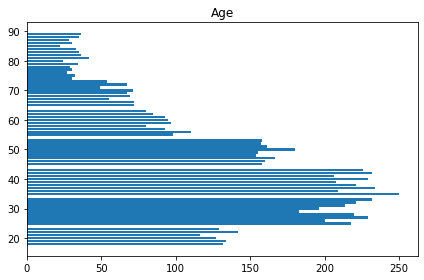

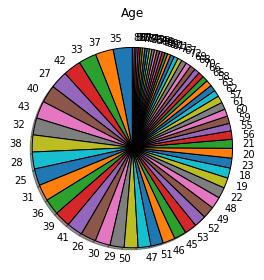

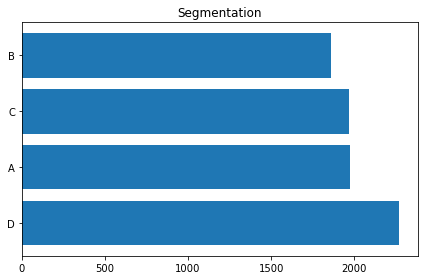

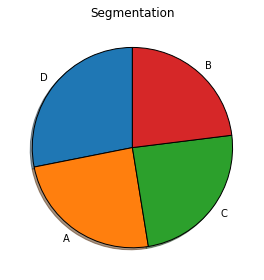

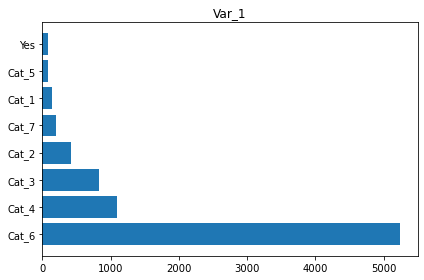

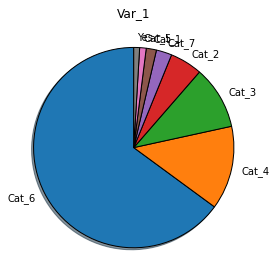

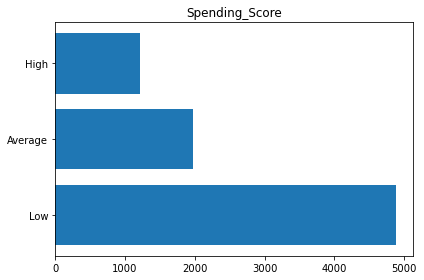

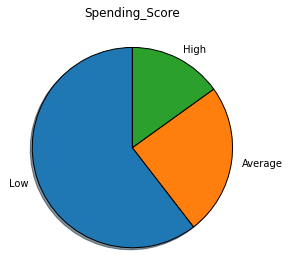

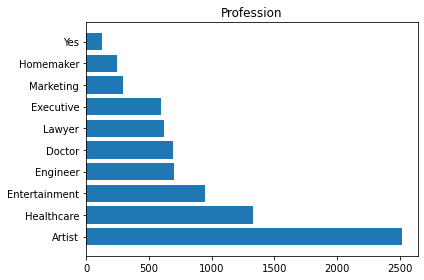

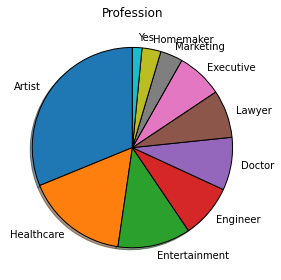

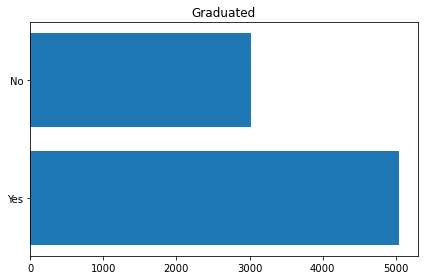

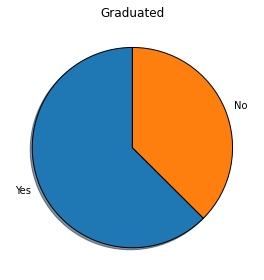

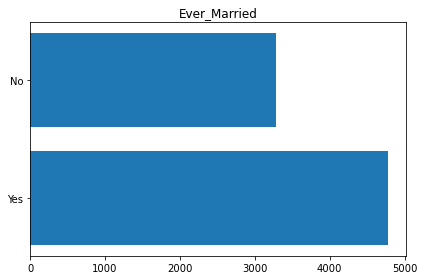

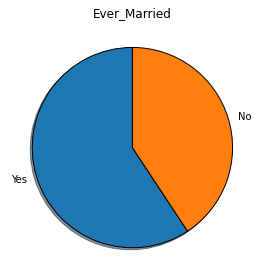

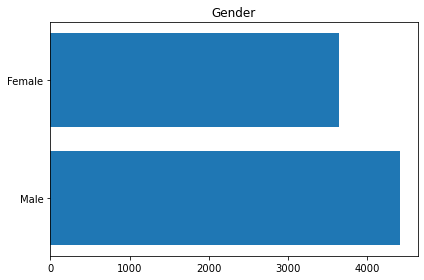

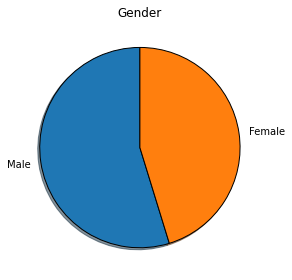

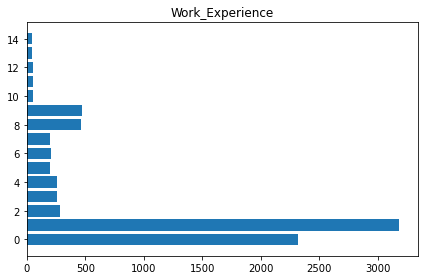

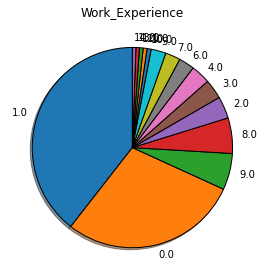

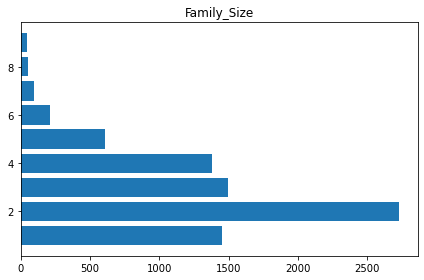

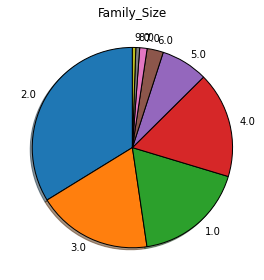

In [16]:
features = data.columns.values
for feature in features:
    draw_bar_plot(feature, data)
    draw_pie(feature, data)

In [16]:
data.isnull().sum()

Age                0
Segmentation       0
Var_1              0
Spending_Score     0
Profession         0
Graduated          0
Ever_Married       0
Gender             0
Work_Experience    0
Family_Size        0
dtype: int64

In [17]:
from sklearn.preprocessing import LabelEncoder
categoricals = data.select_dtypes(include=['object']).columns.values
label_encoder = LabelEncoder()
for categorical in categoricals:
    data[categorical] = label_encoder.fit_transform(data[categorical])

In [18]:
data.head(5)

,Age,Segmentation,Var_1,Spending_Score,Profession,Graduated,Ever_Married,Gender,Work_Experience,Family_Size
0,22,3,3,2,5,0,0,1,1.0,4.0
1,38,0,3,0,2,1,1,0,1.0,3.0
2,67,1,5,2,2,1,1,0,1.0,1.0
3,67,1,5,1,7,1,1,1,0.0,2.0
4,40,0,5,1,3,1,1,0,1.0,6.0


In [19]:
#Hopkins Statistic is a way of measuring the cluster tendency of a data set.
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [20]:
hopkins(data)

0.7407181581118715

In [21]:
from sklearn import preprocessing
data_scaled = preprocessing.scale(data)

In [22]:
%matplotlib inline

In [23]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from kmodes.kprototypes import KPrototypes
import matplotlib as mpl 

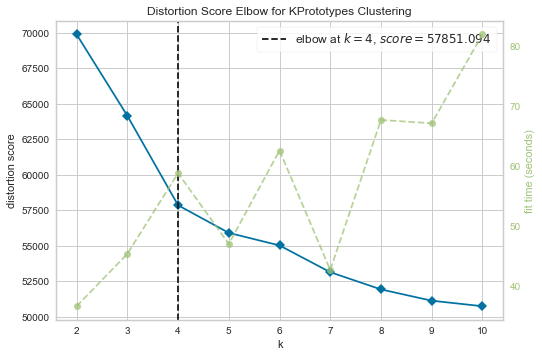

In [24]:
model = KPrototypes(n_init=5)
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(data_scaled,categorical=[1,2,3,4,5,6,7,8])    # Fit the data to the visualizer
visualizer.poof()  

In [43]:
from sklearn.metrics import silhouette_samples, silhouette_score

kp = KPrototypes(n_init=10, n_clusters = 5)
y = kp.fit_predict(data, categorical=[1,2,3,4,5,6,7,8])
score = silhouette_score(data, y)
print(score)

0.3637815208027494


In [84]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

model = KPrototypes(n_clusters=4,max_iter=5,verbose=1, n_init=5)
y = model.fit_predict(data, categorical=[1,2,3,4,5,6,7,8])


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/5, moves: 1648, ncost: 886562.8604912743
Run: 1, iteration: 2/5, moves: 411, ncost: 882631.0207846181
Run: 1, iteration: 3/5, moves: 259, ncost: 880997.3388710577
Run: 1, iteration: 4/5, moves: 161, ncost: 880403.44225948
Run: 1, iteration: 5/5, moves: 85, ncost: 880226.7528293628
Run: 1, iteration: 6/5, moves: 72, ncost: 880043.724052301
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/5, moves: 1608, ncost: 942648.1075471422
Run: 2, iteration: 2/5, moves: 908, ncost: 920724.5353091188
Run: 2, iteration: 3/5, moves: 831, ncost: 904947.4277870697
Run: 2, iteration: 4/5, moves: 742, ncost: 890504.538856302
Run: 2, iteration: 5/5, moves: 513, ncost: 883531.9745274218
Run: 2, iteration: 6/5, moves: 297, ncost: 881184.2187087672
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/5, moves: 1

{'target': {'target': array([3, 1, 0, ..., 3, 3, 1], dtype=uint16)}}